# Hegslemann Krause Model


In [1]:
import random
import numpy as np
import math
import pylab
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
from ipywidgets import interact, interactive, fixed, interact_manual
sns.set()

In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector


## The Basic HK Model 

Suppose that $N=\{1, \ldots, n\}$ is a set of agents.  Fix the following parameters: 
1. $T\in [0, 1]$ is the truth
2. $\tau\in [0, 1]$ is the truth seeking parameter
3. $\epsilon\in [0, 1]$ is the agent's bounded confidence parameter

For each $i\in N$ and $t\in\mathbb{N}$ let $x_{i,t}\in [0, 1]$ be agent $i$'s opinion at time $t$.   At each round the agents update their opinion as follows: 

$$x_{i,t+1} = \tau \times T + (1-\tau) * \frac{\sum_{j\in \mathcal{N}(i,t)} x_{j,t}}{|\mathcal{N}(i,t)|}$$

where $\mathcal{N}(i,t)=\{j\mid |x_{i,t} - x_{j,t}| < \epsilon\}$ is the set of agent $i$'s confidants at time $t$. 


In [80]:
class Expert(Agent):

    def __init__(self, unique_id,  model, init_opinion, conf, truth_seeking, simultaneous_update = True):

        super().__init__(unique_id, model)
        self.opinion = init_opinion
        self.old_opinion = init_opinion
        self.conf = conf  
        self.truth_seeking = truth_seeking
        self.simultaneous_update = simultaneous_update
    
    def update(self):
        
        self.old_opinion = self.opinion
        if self.conf == 0: 
            confidants_opinions = [self.old_opinion]
        else:
            confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.old_opinion - a.old_opinion) < self.conf]

        self.opinion = self.truth_seeking * self.model.truth + (1 - self.truth_seeking) * np.average(confidants_opinions)
                
    def update_asynch(self):
        '''update asynchronously: agents update in different order'''
        if self.conf == 0: 
            confidants_opinions = [self.opinion]
        else:
            confidants_opinions = [a.opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.opinion - a.opinion) < self.conf]

        self.opinion = self.truth_seeking * self.model.truth + (1 - self.truth_seeking)* np.average(confidants_opinions)
    
    def step(self):
        
        if self.simultaneous_update: 
            self.update()
        else:
            self.update_asynch()
        
class DeliberationModel(Model):
    def __init__(self, num_experts, truth, conf, truth_seeking, simultaneous_update=True):
        
        self.num_experts = num_experts        
        self.schedule = RandomActivation(self)
        self.truth = truth
        self.conf = conf
        self.running = True
        # Initialize the experts
        agent_id = 0
        for i in range(num_experts): 
            init_opinion = random.random() # initial opinion is a random number between 0 and 1
            e = Expert(i, self, init_opinion, conf, truth_seeking, simultaneous_update = simultaneous_update)
            self.schedule.add(e)
              
    def num_groups(self): 
        '''a group is defined to be a collection of agents whose opinion differs '''
        groups = list()

        opinions = [e.opinion for e in self.schedule.agents]
        for o in opinions: 
            
            for g in groups:
                if math.fabs(max(g + [o]) - min(g + [o])) < self.conf:
                    g.append(o)
                    break
            else:
                groups.append([o])     
        return len(groups)
        
    def step(self):
        self.schedule.step()

```{caution}
Note that the synchronous and asyncronous update methods may lead to different results, as shown by the following two simulations.  In the remainder of this section, we only consider synchronous updates. 
```

In [96]:
num_agents = 50
conf = 0.1  
truth_seeking = 0.05
truth = 0.7
num_trials = 20

m_simult = DeliberationModel(num_agents, truth, conf, truth_seeking)
m_async = DeliberationModel(num_agents, truth, conf, truth_seeking, simultaneous_update = False)

expert_opinions = {e.unique_id:[e.opinion] for e in m_simult.schedule.agents }
expert_opinions_async = {e.unique_id:[e.opinion] for e in m_async.schedule.agents }

for num_trials in range(num_trials): 
    m_simult.step()
    for e in m_simult.schedule.agents: 
        expert_opinions[e.unique_id].append(e.opinion)
    
    m_async.step()
    for e in m_async.schedule.agents: 
        expert_opinions_async[e.unique_id].append(e.opinion)
        


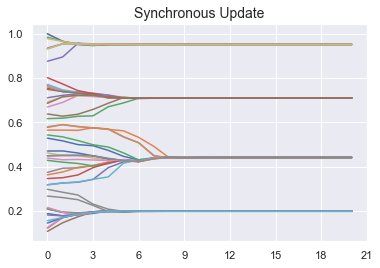

In [116]:
df = pd.DataFrame(expert_opinions)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for e in m_simult.schedule.agents: 
    plt.plot(list(df[e.unique_id]))    
plt.title("Synchronous Update", fontsize=14)
plt.show();


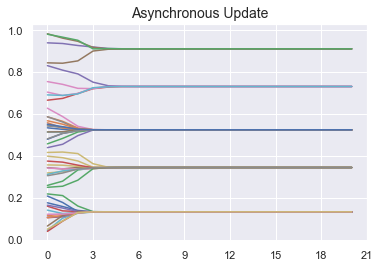

In [115]:
df = pd.DataFrame(expert_opinions_async)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

for e in m_async.schedule.agents: 
    plt.plot(list(df[e.unique_id]))    
plt.title("Asynchronous Update", fontsize=14)
plt.show();

To illustate the model, we can explore the relationship between the `conf` parameter the how many groups of agents there are after 20 rounds.   A group is a set of agents all of whose opinion differ by at most `conf`. 

In [111]:
num_agents = 50
confs = [0.01, 0.05, 0.075, 0.1, 0.2]
truth_seeking = 0.0
truth = 0.5
num_rounds = 20
num_experiments = 1000

avg_num_groups = { conf: 0 for conf in confs }
for conf in confs: 
    
    num_groups = list()
    for e in range(num_experiments):
        m = DeliberationModel(num_agents, truth, conf, truth_seeking)
        for nr in range(num_rounds): 
            m.step()
        num_groups.append(m.num_groups())
    avg_num_groups[conf] = np.average(num_groups)

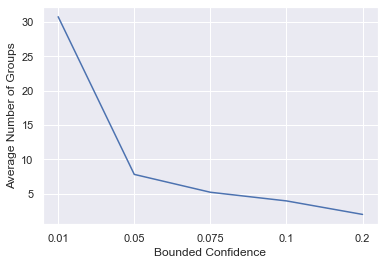

In [120]:
plt.plot([str(c) for c in confs], [avg_num_groups[conf] for conf in confs])
plt.xlabel("Bounded Confidence")
plt.ylabel("Average Number of Groups")
plt.show();

### Adding noise

A natural extension is to add some noise to the input from the world about the true value.  

Let $\nu$ be a bound on the noise, and let $\mathrm{rnd}([-\nu, \nu])$ be the number drawn from a uniform distribution over the interval $[-\nu, \nu]$.  To incorporate noise, we modify the update rule as follows: 


$$x_{i,t+1} = \tau \times (T + \mathrm{rnd}([-\nu, \nu])) + (1-\tau) * \frac{\sum_{j\in \mathcal{N}(i,t)} x_{j,t}}{|\mathcal{N}(i,t)|}$$

where $\tau, T$ and $\mathcal{N}$ are defined as above. 

In [126]:
class Expert(Agent):

    def __init__(self, unique_id,  model, init_opinion, conf, truth_seeking, noise = 0):

        super().__init__(unique_id, model)
        self.opinion = init_opinion
        self.old_opinion = init_opinion
        self.conf = conf  
        self.truth_seeking = truth_seeking
        self.noise = noise
    
    def update(self):
        
        self.old_opinion = self.opinion
        confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                              if math.fabs(self.old_opinion - a.old_opinion) < self.conf]
        
        self.opinion = np.average(confidants_opinions)
    
    def update_with_truth_seeking(self):
        
        self.old_opinion = self.opinion
        if self.conf == 0: 
            confidants_opinions = [self.old_opinion]
        else:

            confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.old_opinion - a.old_opinion) < self.conf]

        self.opinion = self.truth_seeking * self.model.truth + (1-self.truth_seeking)*np.average(confidants_opinions)

    def update_with_noisy_truth_seeking(self):
        
        noise = np.random.uniform(-self.noise,self.noise,1)[0]
        self.old_opinion = self.opinion
        if self.conf == 0: 
            confidants_opinions = [self.old_opinion]
        else:

            confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.old_opinion - a.old_opinion) < self.conf]

        self.opinion = self.truth_seeking * (self.model.truth + noise) + (1-self.truth_seeking)*np.average(confidants_opinions)
    
    def step(self):
        
        if self.truth_seeking is not None: 
            if self.noise >  0:
                self.update_with_noisy_truth_seeking()
            else: 
                self.update_with_truth_seeking()
        else: 
            self.update()

class DeliberationModel(Model):
    def __init__(self, num_experts, truth, conf, truth_seeking, noise = 0):
        
        self.num_experts = num_experts
        self.truth = truth
        self.truth_seeking = truth_seeking
        self.conf = conf
        self.noise = noise
        
        self.schedule = RandomActivation(self)
        
        self.running = True
        
        # Set up agents
        agent_id = 0
        for i in range(num_experts): 
            
            init_opinion = random.random()
            e = Expert(i, self, init_opinion, conf, truth_seeking, noise = self.noise)
            self.schedule.add(e)
        
    def step(self):
        self.schedule.step()

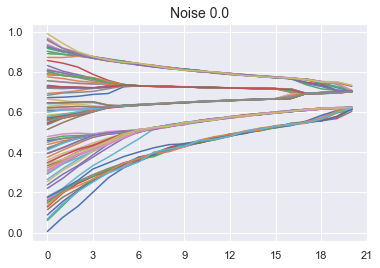

In [136]:
num_agents = 100
conf = 0.05
truth_seeking = 0.1
truth = 0.7
noise = 0.0
num_trials = 20

m = DeliberationModel(num_agents, truth, conf, truth_seeking, noise = noise)

expert_opinions = {e.unique_id:[e.opinion] for e in m.schedule.agents }
for num_trials in range(num_trials): 
    m.step()
    for e in m.schedule.agents: 
        expert_opinions[e.unique_id].append(e.opinion)

df = pd.DataFrame(expert_opinions)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for e in m.schedule.agents: 
    plt.plot(list(df[e.unique_id]))    
plt.title(f"Noise {noise}", fontsize=14)
plt.show();


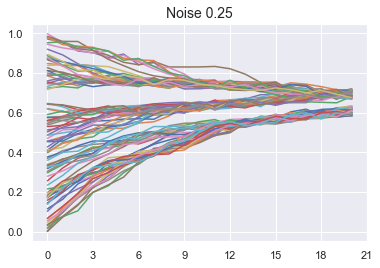

In [137]:
num_agents = 100
conf = 0.05
truth_seeking = 0.1
truth = 0.7
noise = 0.25
num_trials = 20

m = DeliberationModel(num_agents, truth, conf, truth_seeking, noise = noise)

expert_opinions = {e.unique_id:[e.opinion] for e in m.schedule.agents }
for num_trials in range(num_trials): 
    m.step()
    for e in m.schedule.agents: 
        expert_opinions[e.unique_id].append(e.opinion)

df = pd.DataFrame(expert_opinions)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for e in m.schedule.agents: 
    plt.plot(list(df[e.unique_id]))    
plt.title(f"Noise {noise}", fontsize=14)
plt.show();


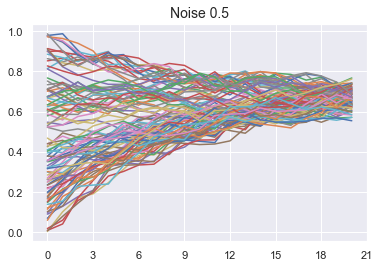

In [138]:
num_agents = 100
conf = 0.05
truth_seeking = 0.1
truth = 0.7
noise = 0.5
num_trials = 20

m = DeliberationModel(num_agents, truth, conf, truth_seeking, noise = noise)

expert_opinions = {e.unique_id:[e.opinion] for e in m.schedule.agents }
for num_trials in range(num_trials): 
    m.step()
    for e in m.schedule.agents: 
        expert_opinions[e.unique_id].append(e.opinion)

df = pd.DataFrame(expert_opinions)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for e in m.schedule.agents: 
    plt.plot(list(df[e.unique_id]))    
plt.title(f"Noise {noise}", fontsize=14)
plt.show();


## Further modifications of the HK model

One final modification of the update rule is to assume that for each $j$, $w_j\in [0, 1]$ is the reputation of agent $j$, where $\sum_j w_j = 1$.  Then, 

$$x_{i,t+1} = \tau \times (T + \mathrm{rnd}([-\nu, \nu])) + (1-\tau) * \frac{\sum_{j\in N(i,t)} x_{j,t}\times w_j}{\sum_j w_j}$$

where the parameters are as above. 


Additional questions/modifications of the model: 

1. All of the  experts always interact with every other expert.  That is, they are supposed to know, at any time, the beliefs of all the other agents. 
2. Learning from the world is a black box. 
3. There is no strategizing or misinformation. 
4. Experts are assumed to have beliefs about a single proposition. What happens when agents have beliefs (either qualitative or quantitative) about multiple propositions (that are possibly logically connected)? 
5. What is the aim of deliberation?  Is it to only reach consensus?  Or do we also want accuracy? 

## Further Reading 

1. I. Douven and  A. Riegler (2010). [Extending the Hegselmann–Krause Model I](https://www.researchgate.net/publication/220245147_Extending_the_Hegselmann-Krause_Model_I#fullTextFileContent), 
Logic Journal of the IGPL, 18:2, pp. 323 - 335.

2. A. Riegler and I. Douven (2010) [Extending the Hegselmann–Krause model II](https://constructivist.info/riegler/pub/Riegler%20A.%20&%20Douven%20I.%20(2010)%20Extending%20the%20Hegselmann%E2%80%93Krause%20model%20II.pdf). In: Czarnecki T., Kijania-Placek K., Poller O. & Wolenski J. (eds.) The analytical way. College Publications: London, pp. 245–258.


3. A. Riegler  and I. Douven  (2009). [Extending the Hegselmann–Krause model III: From single beliefs to complex belief states](https://constructivist.info/riegler/pub/Riegler%20A.%20&%20Douven%20I.%20(2009)%20Extending%20the%20Hegselmann%E2%80%93Krause%20model%20III.pdf), Episteme 6(2), pp. 145 - 163


4. I. Douven and R.  Hegselmann (2021). [Mis- and disinformation in a bounded confidence model](https://www.sciencedirect.com/science/article/abs/pii/S0004370220301648?via%3Dihub), Artificial Intelligence, 291, 103415 (2021)
